In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSSBBSS'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(50)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2194.6| 34.1239|-109.9219|       SNWD|USC00026601|    40|[00 00 00 00 00 0...|1950.0|SSSSBBSS|
|   2194.6| 34.1239|-109.9219|       SNWD|USC00026601|    24|[00 00 00 00 00 0...|1961.0|SSSSBBSS|
|   2194.6| 34.1239|-109.9219|       SNWD|USC00026601|    46|[00 7E 00 7E 00 7...|1963.0|SSSSBBSS|
|   2194.6| 34.1239|-109.9219|       SNWD|USC00026601|     2|[00 00 00 00 00 0...|1964.0|SSSSBBSS|
|   2194.6| 34.1239|-109.9219|       SNWD|USC00026601|    31|[00 7E 00 7E 00 7...|1966.0|SSSSBBSS|
|   2194.6| 34.1239|-109.9219|       SNWD|USC00026601|     4|[60 56 60 56 C0 5...|1967.0|SSSSBBSS|
|   2194.6| 34.1239|-109.9219|       SNWD|USC00026601|     7|[8C 5F 24 5F F0 5...|1968.0|SSSSBBSS|
|   2194.6

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

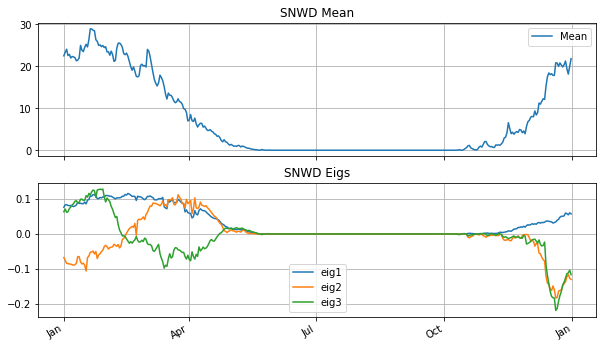

In [7]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [8]:

v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

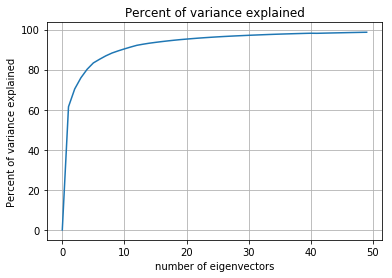

In [9]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:50]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [10]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [11]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1991
after filter 393


In [12]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [36]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [14]:
# Sort entries by increasing values of res_3
df3=df3.sort(df3.res_3,ascending=True)

In [18]:
df3.show(10)

+------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+--------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|           coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|               res_2|               res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+--------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|11250.303362878178|  4604.783064795819|-1529.9031640891317|   2493.3|SSSSBBSS| 33.9833|  -109.75|       SNWD| 0.1885312293301415|0.052113419455038175|0.036300702755860635|0.9744096918010742|USC00023926|1.61938423E8|     2|[C4 5C C4 5C 5C 5...|

In [15]:
#Sorted according to residual error 3
df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_1,ascending = False)
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_1,ascending = True)

rows=df4.take(12)
df4.select('coeff_1','res_2').show(4)
df5.select('coeff_1','res_2').show(4)

+------------------+--------------------+
|           coeff_1|               res_2|
+------------------+--------------------+
|11602.290221681424| 0.21372328012658776|
|11250.303362878178|0.052113419455038175|
|11183.467759022718| 0.05733362444014835|
|11159.371711325743| 0.08046261216771944|
+------------------+--------------------+
only showing top 4 rows

+-----------------+-------------------+
|          coeff_1|              res_2|
+-----------------+-------------------+
|702.9681067961403| 0.3551444996880576|
|926.7774369083135|0.30160210804664245|
|958.8028660767172| 0.3335368075230066|
|965.6663382728887| 0.2928017492254335|
+-----------------+-------------------+
only showing top 4 rows



In [78]:
df4=df3.filter(df3.res_3<0.3).sort(df3.coeff_3, ascending = True)
rows=df4.take(12)
df4.select('coeff_2', 'res_1','res_2', 'res_3').show(12)

+-------------------+-------------------+--------------------+--------------------+
|            coeff_2|              res_1|               res_2|               res_3|
+-------------------+-------------------+--------------------+--------------------+
| -2830.976094125225|  0.963025302051495|  0.5201755025978396| 0.11055199661052939|
|  1598.458256116783|0.24471057918575148| 0.20960290914655524| 0.10984094089955121|
| 2012.8344979228127| 0.2595100592794007|  0.1966234865941382| 0.11039546743011636|
|-2254.0368793808316| 0.9721305927409067|  0.5491670922864546| 0.13992714748048052|
|-1949.1549619483042| 0.9758875267814696|  0.5708251934271497| 0.13743263943874093|
| -1795.401215075647| 0.9902953087179003|  0.6315396915228648|  0.1842213526680553|
|-1704.8402404425954| 0.8312716923921527|  0.5667461356618878|  0.2418538765882311|
|  1268.582582203503|0.12059609606459706|  0.1022072978033054| 0.07213881746280024|
|-1578.0541150628405|  0.977454452350469|  0.5309440397349741|  0.1330095608

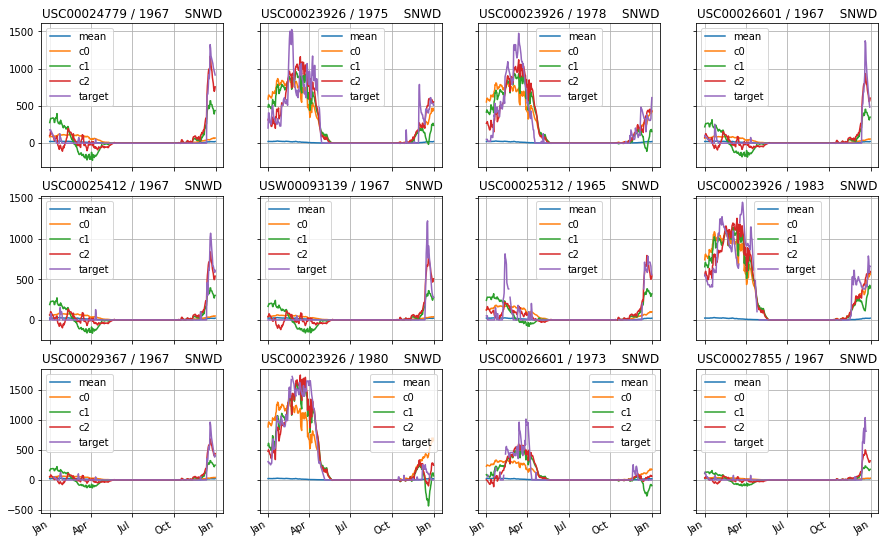

In [79]:
plot_recon_grid(rows)

In [17]:
df3.sort


<bound method DataFrame.sort of DataFrame[coeff_1: double, coeff_2: double, coeff_3: double, elevation: double, label: string, latitude: double, longitude: double, measurement: string, res_1: double, res_2: double, res_3: double, res_mean: double, station: string, total_var: double, undefs: bigint, vector: binary, year: double]>

In [54]:
df4=df3.filter(df3.res_3<0.3).sort(df3.coeff_3, ascending = False)
rows=df4.take(12)
df4.select('coeff_3', 'res_1','res_2', 'res_3').show(12)

+------------------+-------------------+-------------------+-------------------+
|           coeff_3|              res_1|              res_2|              res_3|
+------------------+-------------------+-------------------+-------------------+
| 1898.158307323008| 0.2220532808782985|0.21372328012658776|0.20825913397318485|
|1878.3138870790624| 0.6133806757170616|0.42194938822645695|0.16413568061759465|
| 1791.958042402031|0.20749524418247164|0.18540750917483392| 0.1001590453572007|
|1572.9172479236597|0.37906997118961316|0.30928930467322824| 0.1490284072919404|
|1527.4893698067515| 0.5116644719158371|0.44728727101899046| 0.2803286463481053|
|1457.3312395078808| 0.2534683905880077|0.20110760669312727| 0.1301335546259548|
|1374.4216792188845| 0.7063754221828714| 0.5921246340907056|0.28163494457074634|
| 1308.591470069473|0.22946556193341172| 0.2167120593007177| 0.1378200726749717|
|1231.9999069593132| 0.6027564771968255|0.34838113028829854| 0.2282407887792156|
|1152.8005543210597|0.368015

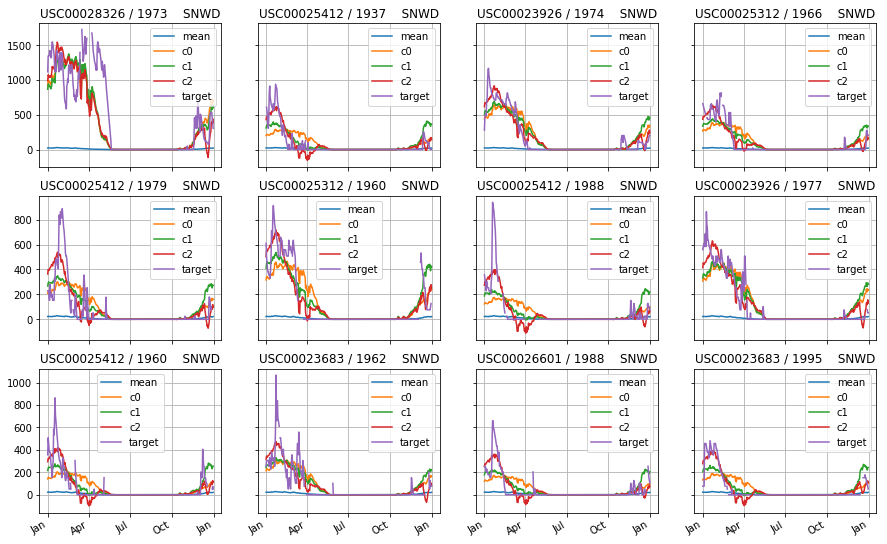

In [55]:
plot_recon_grid(rows)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.959186280744
residual normalized norm  after mean + top eigs: [ 0.9630253  0.5201755  0.110552 ]


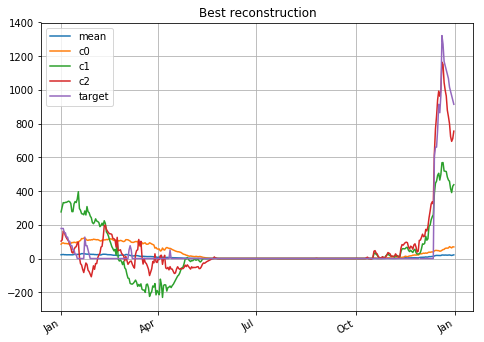

In [60]:
df4=df3.filter(df3.res_3<0.3).sort(df3.coeff_2, ascending = True)
rows=df4.take(12)
#df4.select('coeff_2', 'res_1','res_2', 'res_3').show(12)
row=rows[2]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [63]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    #vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

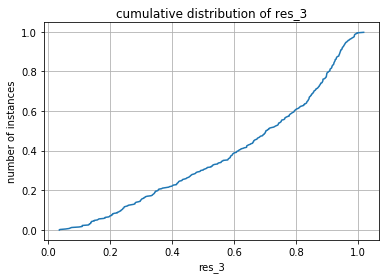

In [68]:
plot_CDF('res_3')

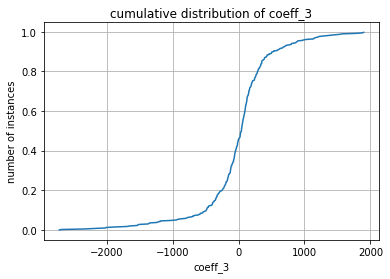

In [71]:
plot_CDF('coeff_3')

In [72]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [73]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
4.7M	../../Data/Weather/US_Weather_BBSBSBSB.parquet
3.3M	../../Data/Weather/US_Weather_SSSSBBSS.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
3.9M	../../Data/Weather/decon_BBBSBBBB_PRCP.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
2.3M	../../Data/Weather/decon_SSSSBBSS_SNWD.parquet
